<a href="https://www.kaggle.com/agnishwarbagchi/finger-classification-cnn?scriptVersionId=88774473" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [2]:
import numpy as np
import cv2
import os
import pandas as pd

In [3]:
def extract_label(img_path, train=True):
    filename, _ = os.path.splitext(os.path.basename(img_path))
    subject_id, etc = filename.split('__')
    
    if train:
        gender, lr, finger, _, _ = etc.split('_')
    else:
        gender, lr, finger, _ = etc.split('_')
    
    gender = 0 if gender == 'M' else 1
    lr =0 if lr == 'Left' else 1
    
    if finger == 'thumb':
        finger = 0
    elif finger == 'index':
        finger = 1
    elif finger == 'middle':
        finger = 2
    elif finger == 'ring':
        finger = 3
    elif finger == 'little':
        finger = 4
     
    return np.array([finger], dtype=np.uint16)

In [4]:
IMG_SIZE = 96

def load_data(path, train):
    print("loading data from: ", path)
    data = []
    for img in os.listdir(path):
        try:
            img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
            img_resize = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
            label = extract_label(os.path.join(path, img),train)
            data.append([label[0], img_resize ])
        except Exception as e:
            pass
    return data

In [5]:
Real_path = "../input/socofing/SOCOFing/Real"
Easy_path = "../input/socofing/SOCOFing/Altered/Altered-Easy"
Medium_path = "../input/socofing/SOCOFing/Altered/Altered-Medium"
Hard_path = "../input/socofing/SOCOFing/Altered/Altered-Hard"

easy_data = load_data(Easy_path, train = True)
medium_data = load_data(Medium_path, train = True)
hard_data = load_data(Hard_path, train = True)
test = load_data(Real_path, train = False)

data = np.concatenate([easy_data,medium_data,hard_data],axis=0)

loading data from:  ../input/socofing/SOCOFing/Altered/Altered-Easy
loading data from:  ../input/socofing/SOCOFing/Altered/Altered-Medium
loading data from:  ../input/socofing/SOCOFing/Altered/Altered-Hard
loading data from:  ../input/socofing/SOCOFing/Real


<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


In [6]:
import random
random.shuffle(data)
random.shuffle(test)

In [7]:
data[0]

array([4, array([[160, 158, 158, ...,   0,   0,   0],
                 [160, 105, 121, ...,   0,   0,   0],
                 [160, 105, 255, ...,   0,   0,   0],
                 ...,
                 [  0,   0,   0, ...,   0,   0,   0],
                 [  0,   0,   0, ...,   0,   0,   0],
                 [  0,   0,   0, ...,   0,   0,   0]], dtype=uint8)],
      dtype=object)

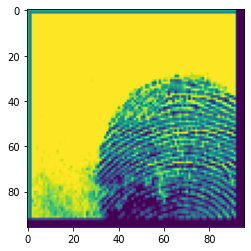

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.imshow(data[0][1])

In [9]:
X, y = [],[]

for label, feature in data:
    y.append(label)
    X.append(feature)

 
X_train = np.array(X).reshape(-1,IMG_SIZE,IMG_SIZE,1)
X_train = X_train/255

y_train = np.array(y)

In [10]:
X_train.shape, y_train.shape

((49270, 96, 96, 1), (49270,))

In [11]:
np.unique(y_train)

array([0, 1, 2, 3, 4], dtype=uint16)

In [12]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense,Dropout, Flatten
from tensorflow.keras import layers
from tensorflow.keras import optimizers

In [13]:
model = Sequential([
    Conv2D(32, 3, padding='same', activation='relu',kernel_initializer='he_uniform',
           input_shape = [IMG_SIZE, IMG_SIZE, 1]),
    MaxPooling2D(2),
    Conv2D(32, 3, padding='same', kernel_initializer='he_uniform', activation='relu'),
    MaxPooling2D(2),
    Flatten(),
    Dense(128, kernel_initializer='he_uniform', activation='relu'),
    Dense(5,activation='softmax'),
    
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 96, 96, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 48, 48, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 48, 48, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 24, 24, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 18432)             0         
_________________________________________________________________
dense (Dense)                (None, 128)               2359424   
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 6

2022-02-26 07:23:39.301792: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-26 07:23:39.397469: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-26 07:23:39.398190: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-26 07:23:39.399117: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [14]:
model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])

history = model.fit(X_train,y_train, batch_size=128, epochs=30, validation_split=0.2)

2022-02-26 07:23:42.167676: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1453031424 exceeds 10% of free system memory.
2022-02-26 07:23:43.630263: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1453031424 exceeds 10% of free system memory.
2022-02-26 07:23:44.710647: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/30


2022-02-26 07:23:45.907495: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


308/308 [==============================] - 12s 19ms/step - loss: 1.4749 - accuracy: 0.5011 - val_loss: 0.9061 - val_accuracy: 0.6482
Epoch 2/30
308/308 [==============================] - 5s 15ms/step - loss: 0.6675 - accuracy: 0.7524 - val_loss: 0.5988 - val_accuracy: 0.7760
Epoch 3/30
308/308 [==============================] - 5s 15ms/step - loss: 0.3542 - accuracy: 0.8862 - val_loss: 0.3719 - val_accuracy: 0.8718
Epoch 4/30
308/308 [==============================] - 5s 15ms/step - loss: 0.1691 - accuracy: 0.9534 - val_loss: 0.2789 - val_accuracy: 0.9065
Epoch 5/30
308/308 [==============================] - 5s 15ms/step - loss: 0.0879 - accuracy: 0.9790 - val_loss: 0.1940 - val_accuracy: 0.9387
Epoch 6/30
308/308 [==============================] - 5s 15ms/step - loss: 0.0440 - accuracy: 0.9920 - val_loss: 0.1911 - val_accuracy: 0.9411
Epoch 7/30
308/308 [==============================] - 5s 15ms/step - loss: 0.0262 - accuracy: 0.9962 - val_loss: 0.1502 - val_accuracy: 0.9537
Epoch 8/3

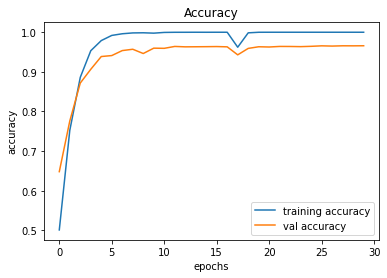

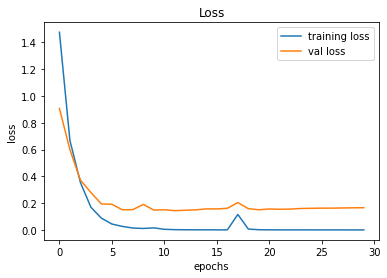

In [15]:
plt.figure(0)
plt.plot(history.history['accuracy'], label='training accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.title("Accuracy")
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()
plt.figure(1)
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

In [16]:
X_test,y_test = [],[]

for label, feature in test:
    y_test.append(label)
    X_test.append(feature)
    
X_test = np.array(X_test).reshape(-1,IMG_SIZE,IMG_SIZE,1)
X_test = X_test/255

y_test = np.array(y_test)

In [17]:
model.evaluate(X_test,y_test)

188/188 [==============================] - 1s 3ms/step - loss: 0.0441 - accuracy: 0.9943


[0.04406782612204552, 0.9943333268165588]

In [18]:
predictions = model.predict(X_test)
predictions[:5]

array([[1.0707630e-20, 3.0948662e-08, 5.6548521e-07, 9.9999940e-01,
        1.9404107e-09],
       [1.0000000e+00, 1.2045032e-12, 3.1602769e-11, 1.9268188e-19,
        2.8363891e-19],
       [3.8438601e-16, 1.0000000e+00, 1.0324832e-12, 1.1251669e-15,
        3.1750352e-16],
       [4.7372525e-16, 1.6695605e-10, 9.9998450e-01, 1.5457714e-05,
        5.4072246e-12],
       [1.1324697e-15, 1.8166645e-07, 2.9519995e-12, 5.0767991e-08,
        9.9999976e-01]], dtype=float32)

In [19]:
predicted = [np.argmax(i) for i in predictions]
predicted[:5]

[3, 0, 1, 2, 4]

In [22]:
import tensorflow as tf
cm = tf.math.confusion_matrix(labels=y_test,predictions=predicted)

Text(33.0, 0.5, 'Truth')

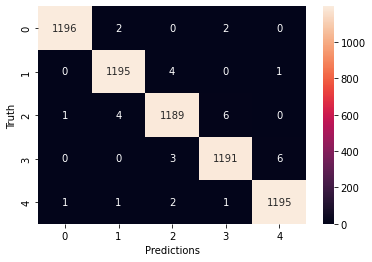

In [23]:
import seaborn as sn

sn.heatmap(cm,annot=True,fmt='d')
plt.xlabel("Predictions")
plt.ylabel("Truth")